## Check whether all seeds were properly done

In [1]:
1+2

3

In [1]:
import os
import glob
from pathlib import Path


log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"

group_name = "dmcgb_reset"
#group_name = "Hansen_repo"

exp_name = "svea_cnn11_randomoverlay_policy_reset_rr1"
#exp_name = "svea_cnn4_randomoverlay"

log_dir = Path(log_dir, group_name, exp_name)

# Traverse through all model.pt files and collect their paths and seed numbers
pt_files = glob.glob(os.path.join(log_dir, '**/500000.pt'), recursive=True)

# Collecting the .pt files along with their seed numbers
pt_files_with_seed = []
for pt_file in pt_files:
    # Split the file path into components
    components = pt_file.split(os.sep)
    
    # Get the seed number (assuming it is always positioned at the -3 index)
    seed_number = components[-3]
    
    # Store the file path along with the seed number
    pt_files_with_seed.append((pt_file, seed_number))

# Print all the collected .pt files along with their seed numbers
print("Number of successful runs: ", len(pt_files_with_seed))
#for pt_file, seed_number in pt_files_with_seed:
    #print(f"File path: {pt_file}, Seed number: {seed_number}")

Number of successful runs:  35


## Plotting distractingcs results for each experiment individually

In [2]:
import torch
# Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
distracting_cs_pt_files = glob.glob(os.path.join(log_dir, '**/distractingcs_evalresults.pt'), recursive=True)

# Create a dictionary with keys as "domain_task" and values as paths to .pt files
distracting_cs_pt_files_dict = {}
for pt_file in distracting_cs_pt_files:
    # Split the file path into components
    components = pt_file.split(os.sep)
    
    # Get the domain and task names (adjust the indices as per your directory structure)
    domain_name = components[-3]
    task_name = components[-2]
    
    # Create a key combining domain and task names
    key = f"{domain_name}_{task_name}"
    
    # Add the file path to the dictionary
    distracting_cs_pt_files_dict[key] = torch.load(pt_file)

# Print the dictionary
print(len(distracting_cs_pt_files_dict.keys()))
#for key, value in distracting_cs_pt_files_dict.items():
#    print(f"Key: {key}")


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


35


In [3]:
distracting_cs_pt_files_dict['walker_stand_0']

{'args': Namespace(action_repeat=4, actor_beta=0.9, actor_log_std_max=2, actor_log_std_min=-10, actor_lr=0.001, actor_update_freq=2, algorithm='svea', alpha_beta=0.5, alpha_lr=0.0001, aux_beta=0.9, aux_lr=0.001, aux_update_freq=2, batch_size=128, critic_beta=0.9, critic_lr=0.001, critic_target_reset='copy_critic', critic_target_update_freq=2, critic_tau=0.01, discount=0.99, distracting_cs_intensity=0.0, do_encoder_reset=False, do_policy_reset=False, domain_name='walker', encoder_tau=0.05, encoder_type='cnn', episode_length=1000, eval_episodes=100, eval_freq=50000, eval_mode='color_hard', exp_name='svea_cnn11_randomoverlay_policy_reset_rr1', frame_stack=3, group_name='dmcgb_reset', hard_aug_type='random_overlay', hidden_dim=1024, image_crop_size=84, image_size=84, init_steps=1000, init_temperature=0.1, log_dir='logs', num_filters=32, num_head_layers=0, num_shared_layers=11, projection_dim=100, replay_ratio=1, reset_interval_steps=25000, save_freq=100000, save_video=True, seed=0, shrink_

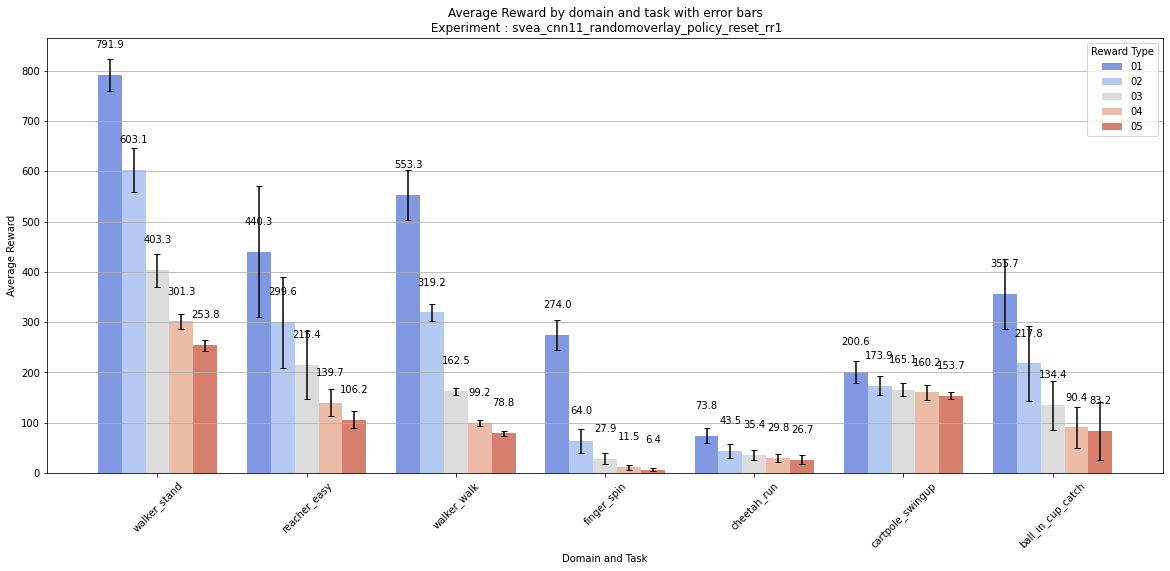

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Dictionary to store rewards per task (domain_task as key)
reward_data = defaultdict(lambda: defaultdict(list))

# Populate reward_data with reward values from data_dict
for key, value in distracting_cs_pt_files_dict.items():
    domain_task = "_".join(key.split("_")[:-1])
    reward_data[domain_task]['01'].append(value.get('distractingcs 01 reward', 0))
    reward_data[domain_task]['02'].append(value.get('distractingcs 02 reward', 0))
    reward_data[domain_task]['03'].append(value.get('distractingcs 03 reward', 0))
    reward_data[domain_task]['04'].append(value.get('distractingcs 04 reward', 0))
    reward_data[domain_task]['05'].append(value.get('distractingcs 05 reward', 0))

# Creating a DataFrame to hold all the data
data = []

for task, rewards in reward_data.items():
    data.append([task, '01', np.mean(rewards['01']), np.std(rewards['01'])])
    data.append([task, '02', np.mean(rewards['02']), np.std(rewards['02'])])
    data.append([task, '03', np.mean(rewards['03']), np.std(rewards['03'])])
    data.append([task, '04', np.mean(rewards['04']), np.std(rewards['04'])])
    data.append([task, '05', np.mean(rewards['05']), np.std(rewards['05'])])

df = pd.DataFrame(data, columns=['Task', 'Reward Type', 'Average Reward', 'STD'])
#df = df.reset_index(inplace=True)

# Creating the barplot using seaborn
plt.figure(figsize=(20,8))
barplot = sns.barplot(x='Task', y='Average Reward', hue='Reward Type', data=df, errorbar='sd', capsize=.1, palette='coolwarm')

bar_width = barplot.patches[0].get_width()

for i, (task, reward_type) in enumerate(df[['Task', 'Reward Type']].values):
    # Find the right patch object that matches the current task and reward type
    patch = [
        p for p in barplot.patches 
        if abs(p.get_x() + p.get_width() / 2 - (barplot.get_xticks()[barplot.get_xticks().tolist().index(i // 5)] + (i % 5 - 2) * bar_width)) < 0.01
    ][0]

    y_value = patch.get_height()
    x_value = patch.get_x() + patch.get_width() / 2.0
    std_dev = df['STD'].iloc[i]
    
    # Draw the error bars
    barplot.errorbar(
        x=x_value, 
        y=y_value, 
        yerr=std_dev, 
        color='black',  # Set a color for the error bars
        capsize=3  # Set a cap size for the error bars
    )


# Adding the actual values on top of the bars
bar_width = barplot.patches[0].get_width()

for i, (task, reward_type) in enumerate(df[['Task', 'Reward Type']].values):
    # Find the right patch object that matches the current task and reward type
    patch = [
        p for p in barplot.patches 
        if abs(p.get_x() + p.get_width() / 2 - (barplot.get_xticks()[barplot.get_xticks().tolist().index(i // 5)] + (i % 5 - 2) * bar_width)) < 0.01
    ][0]

    height = patch.get_height()
    if np.isnan(height):
        height = 0

    barplot.annotate(f"{df['Average Reward'].iloc[i]:.1f}", 
                     (patch.get_x() + patch.get_width() / 2., height), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 30), 
                     textcoords = 'offset points')
                     

# Setting the labels and title
plt.xlabel('Domain and Task')
plt.ylabel('Average Reward')
plt.title(f'Average Reward by domain and task with error bars\n Experiment : {exp_name}')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

In [5]:
import torch
import os
import glob
from pathlib import Path

log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"

group_name = "dmcgb_reset"
#group_name = "Hansen_repo"

exp_name = "svea_cnn4_randomoverlay_policy_reset_rr1"
#exp_name = "svea_cnn4_randomoverlay"

log_dir = Path(log_dir, group_name, exp_name)

# Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
distracting_cs_pt_files = glob.glob(os.path.join(log_dir, '**/distractingcs_evalresults.pt'), recursive=True)

# Create a dictionary with keys as "domain_task" and values as paths to .pt files
distracting_cs_pt_files_dict = {}
for pt_file in distracting_cs_pt_files:
    # Split the file path into components
    components = pt_file.split(os.sep)
    
    # Get the domain and task names (adjust the indices as per your directory structure)
    domain_name = components[-3]
    task_name = components[-2]
    
    # Create a key combining domain and task names
    key = f"{domain_name}_{task_name}"
    
    # Add the file path to the dictionary
    distracting_cs_pt_files_dict[key] = torch.load(pt_file)

# Print the dictionary
print(len(distracting_cs_pt_files_dict.keys()))
#for key, value in distracting_cs_pt_files_dict.items():
#    print(f"Key: {key}")


35


In [6]:
log_dir

PosixPath('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs/dmcgb_reset/svea_cnn4_randomoverlay_policy_reset_rr1')

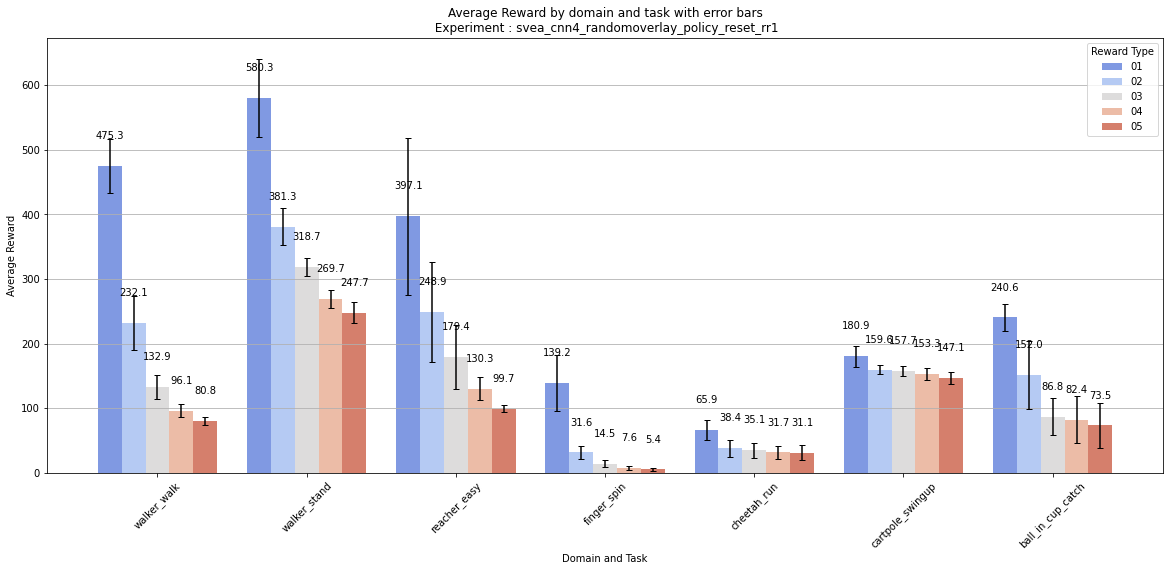

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Dictionary to store rewards per task (domain_task as key)
reward_data = defaultdict(lambda: defaultdict(list))

# Populate reward_data with reward values from data_dict
for key, value in distracting_cs_pt_files_dict.items():
    domain_task = "_".join(key.split("_")[:-1])
    reward_data[domain_task]['01'].append(value.get('distractingcs 01 reward', 0))
    reward_data[domain_task]['02'].append(value.get('distractingcs 02 reward', 0))
    reward_data[domain_task]['03'].append(value.get('distractingcs 03 reward', 0))
    reward_data[domain_task]['04'].append(value.get('distractingcs 04 reward', 0))
    reward_data[domain_task]['05'].append(value.get('distractingcs 05 reward', 0))

# Creating a DataFrame to hold all the data
data = []

for task, rewards in reward_data.items():
    data.append([task, '01', np.mean(rewards['01']), np.std(rewards['01'])])
    data.append([task, '02', np.mean(rewards['02']), np.std(rewards['02'])])
    data.append([task, '03', np.mean(rewards['03']), np.std(rewards['03'])])
    data.append([task, '04', np.mean(rewards['04']), np.std(rewards['04'])])
    data.append([task, '05', np.mean(rewards['05']), np.std(rewards['05'])])

df = pd.DataFrame(data, columns=['Task', 'Reward Type', 'Average Reward', 'STD'])
#df = df.reset_index(inplace=True)

# Creating the barplot using seaborn
plt.figure(figsize=(20,8))
barplot = sns.barplot(x='Task', y='Average Reward', hue='Reward Type', data=df, errorbar='sd', capsize=.1, palette='coolwarm')

bar_width = barplot.patches[0].get_width()

for i, (task, reward_type) in enumerate(df[['Task', 'Reward Type']].values):
    # Find the right patch object that matches the current task and reward type
    patch = [
        p for p in barplot.patches 
        if abs(p.get_x() + p.get_width() / 2 - (barplot.get_xticks()[barplot.get_xticks().tolist().index(i // 5)] + (i % 5 - 2) * bar_width)) < 0.01
    ][0]

    y_value = patch.get_height()
    x_value = patch.get_x() + patch.get_width() / 2.0
    std_dev = df['STD'].iloc[i]
    
    # Draw the error bars
    barplot.errorbar(
        x=x_value, 
        y=y_value, 
        yerr=std_dev, 
        color='black',  # Set a color for the error bars
        capsize=3  # Set a cap size for the error bars
    )


# Adding the actual values on top of the bars
bar_width = barplot.patches[0].get_width()

for i, (task, reward_type) in enumerate(df[['Task', 'Reward Type']].values):
    # Find the right patch object that matches the current task and reward type
    patch = [
        p for p in barplot.patches 
        if abs(p.get_x() + p.get_width() / 2 - (barplot.get_xticks()[barplot.get_xticks().tolist().index(i // 5)] + (i % 5 - 2) * bar_width)) < 0.01
    ][0]

    height = patch.get_height()
    if np.isnan(height):
        height = 0

    barplot.annotate(f"{df['Average Reward'].iloc[i]:.1f}", 
                     (patch.get_x() + patch.get_width() / 2., height), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 30), 
                     textcoords = 'offset points')


# Setting the labels and title
plt.xlabel('Domain and Task')
plt.ylabel('Average Reward')
plt.title(f'Average Reward by domain and task with error bars\n Experiment : {exp_name}')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

## Compare DistractingCs results between different experiments

In [8]:
import torch
import os
import glob
from pathlib import Path

log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"

def load_data(exp_name):
    # Replace with your data loading logic
    exp_log_dir = Path(log_dir, exp_name)
    # Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
    distracting_cs_pt_files = glob.glob(os.path.join(exp_log_dir, '**/distractingcs_evalresults.pt'), recursive=True)

    # Create a dictionary with keys as "domain_task" and values as paths to .pt files
    distracting_cs_pt_files_dict = {}
    for pt_file in distracting_cs_pt_files:
        # Split the file path into components
        components = pt_file.split(os.sep)
        
        # Get the domain and task names (adjust the indices as per your directory structure)
        domain_name = components[-3]
        task_name = components[-2]
        
        # Create a key combining domain and task names
        key = f"{domain_name}_{task_name}"
        
        # Add the file path to the dictionary
        distracting_cs_pt_files_dict[key] = torch.load(pt_file)

    # Print the dictionary
    assert len(distracting_cs_pt_files_dict.keys()) == 35

    # Dictionary to store rewards per task (domain_task as key)
    reward_data = defaultdict(lambda: defaultdict(list))

    # Populate reward_data with reward values from data_dict
    for key, value in distracting_cs_pt_files_dict.items():
        domain_task = "_".join(key.split("_")[:-1])
        reward_data[domain_task]['01'].append(value.get('distractingcs 01 reward', 0))
        reward_data[domain_task]['02'].append(value.get('distractingcs 02 reward', 0))
        reward_data[domain_task]['03'].append(value.get('distractingcs 03 reward', 0))
        reward_data[domain_task]['04'].append(value.get('distractingcs 04 reward', 0))
        reward_data[domain_task]['05'].append(value.get('distractingcs 05 reward', 0))

    # Creating a DataFrame to hold all the data
    data = []

    for task, rewards in reward_data.items():
        data.append([task, '01', np.mean(rewards['01']), np.std(rewards['01'])])
        data.append([task, '02', np.mean(rewards['02']), np.std(rewards['02'])])
        data.append([task, '03', np.mean(rewards['03']), np.std(rewards['03'])])
        data.append([task, '04', np.mean(rewards['04']), np.std(rewards['04'])])
        data.append([task, '05', np.mean(rewards['05']), np.std(rewards['05'])])
    
    df = pd.DataFrame(data, columns=['Task', 'Reward Type', 'Average Reward', 'STD'])
    df['Exp Name'] = exp_name
    return df
    

# List of exp_names
exp_names = ["dmcgb_reset/svea_cnn4_randomoverlay_policy_reset_rr1", 
             "dmcgb_reset/svea_cnn11_randomoverlay_policy_reset_rr1"] 

# Create a DataFrame for each exp_name and store them in a list
dfs = [load_data(exp_name) for exp_name in exp_names]

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  from ipykernel import kernelapp as app


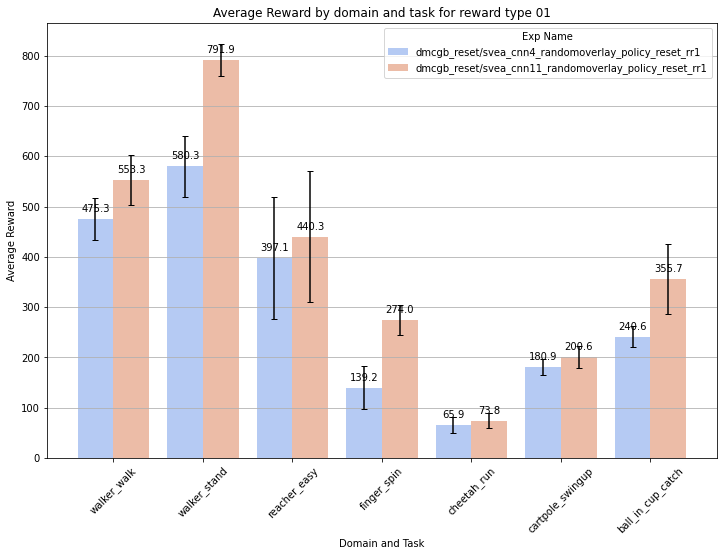

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  from ipykernel import kernelapp as app


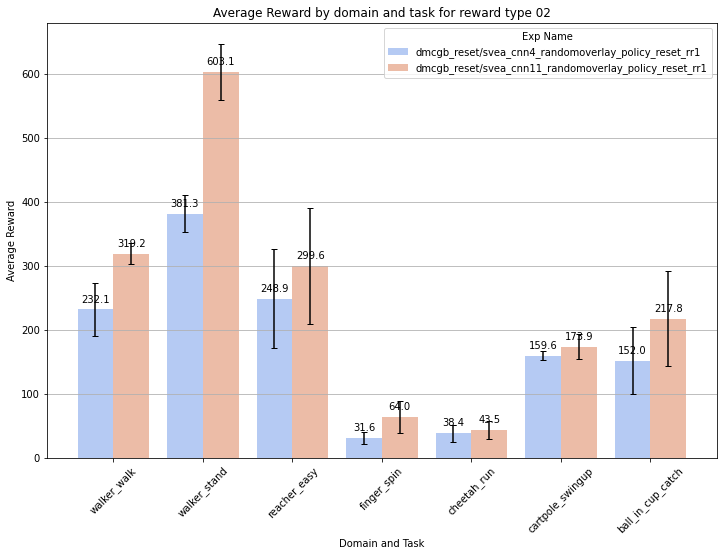

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  from ipykernel import kernelapp as app


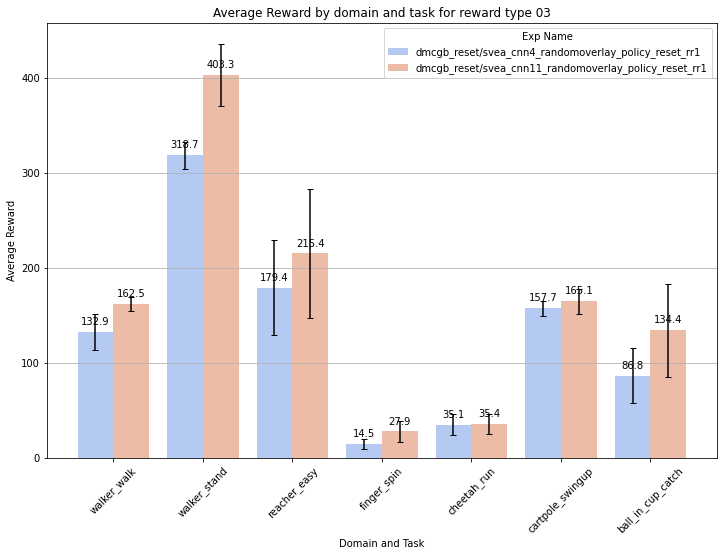

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  from ipykernel import kernelapp as app


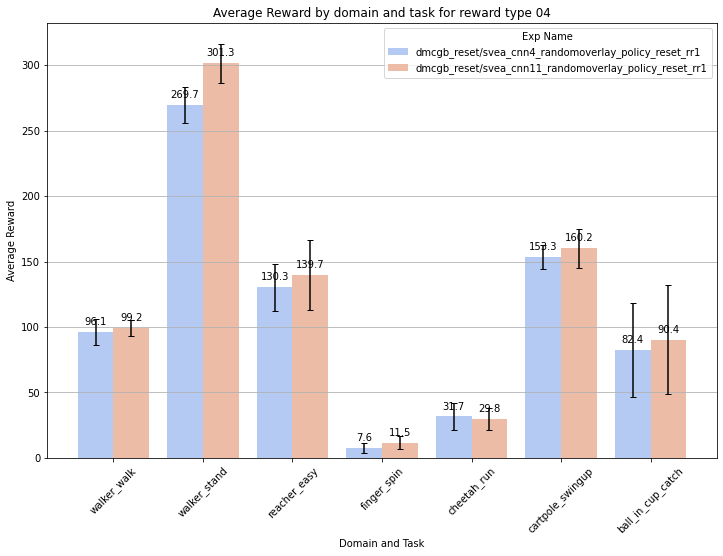

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  from ipykernel import kernelapp as app


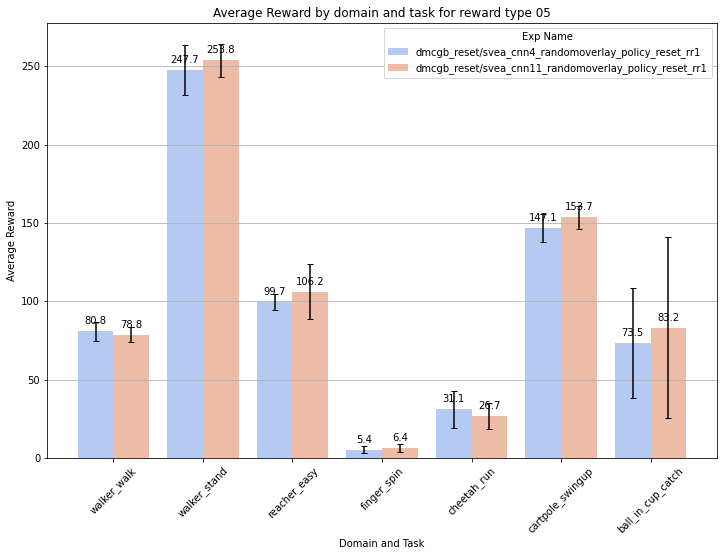

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_reward_types = df['Reward Type'].unique()

for reward_type in unique_reward_types:

    # Subset the data for the current reward type
    subset_df = df[df['Reward Type'] == reward_type].reset_index(drop=True)

    # Create a new figure for each reward type with increased size
    plt.figure(figsize=(12, 8))
    
    # Create the bar plot without seaborn's error bars
    barplot = sns.barplot(x='Task', y='Average Reward', hue='Exp Name', data=subset_df, ci=None, capsize=.1, palette='coolwarm')

    for i, patch in enumerate(barplot.patches):
        # Finding the corresponding data point
        y_value = patch.get_height()
        x_value = patch.get_x() + patch.get_width() / 2.0
        
        hue_col = barplot.get_legend().texts[i // len(subset_df['Task'].unique())].get_text()
        x_tick_label = barplot.get_xticklabels()[i % len(subset_df['Task'].unique())].get_text()

        correct_avg_reward = subset_df[(subset_df['Task'] == x_tick_label) & 
                                    (subset_df['Exp Name'] == hue_col)]['Average Reward'].values[0]

        std_dev = subset_df[(subset_df['Task'] == x_tick_label) & 
                            (subset_df['Exp Name'] == hue_col)]['STD'].values[0]

        # Annotate the bars with the average reward values from the subset_df
        barplot.annotate(
            f"{correct_avg_reward:.1f}", 
            (x_value, y_value),
            ha='center', va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
        
        # Adding custom error bars
        barplot.errorbar(
            x=x_value, 
            y=y_value, 
            yerr=std_dev, 
            color='black',
            capsize=3
        )
    
    # Set the title to include the reward type
    plt.title(f'Average Reward by domain and task for reward type {reward_type}')
    
    # Setting the labels and title
    plt.xlabel('Domain and Task')
    plt.ylabel('Average Reward')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # Show the plot
    plt.show()

35
35
35
35


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



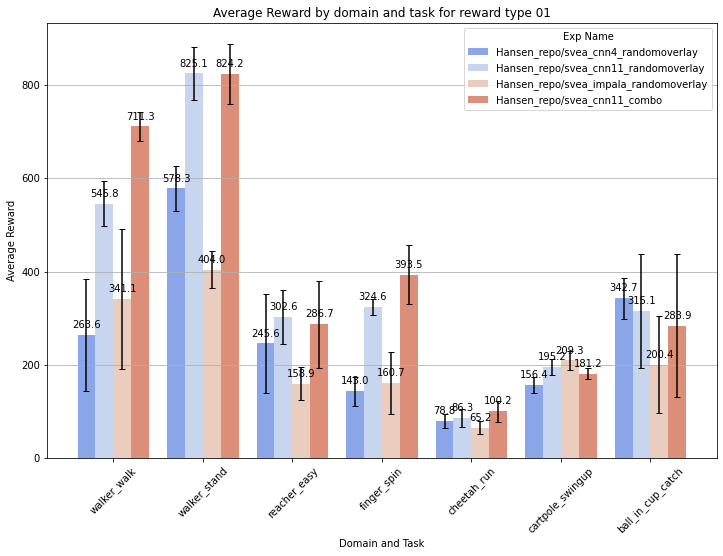

                                       Average Reward
Exp Name                                             
Hansen_repo/svea_cnn11_combo               397.299772
Hansen_repo/svea_cnn11_randomoverlay       370.674848
Hansen_repo/svea_cnn4_randomoverlay        258.342849
Hansen_repo/svea_impala_randomoverlay      219.950906


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



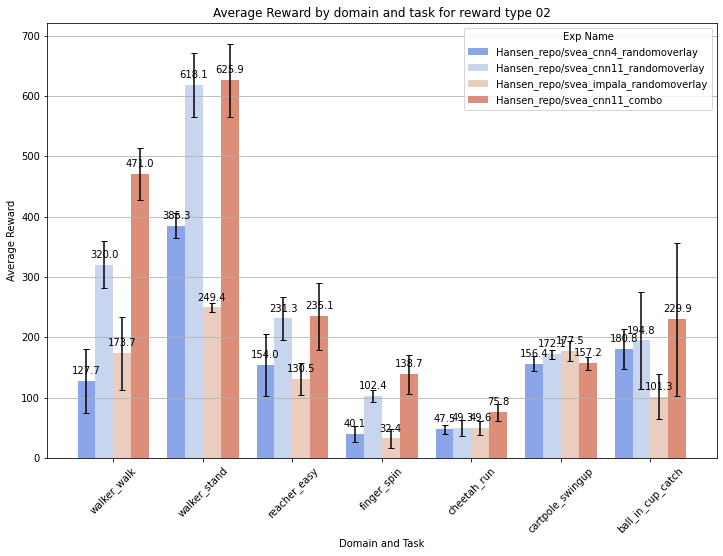

                                       Average Reward
Exp Name                                             
Hansen_repo/svea_cnn11_combo               276.220346
Hansen_repo/svea_cnn11_randomoverlay       241.154076
Hansen_repo/svea_cnn4_randomoverlay        155.966243
Hansen_repo/svea_impala_randomoverlay      130.656077


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



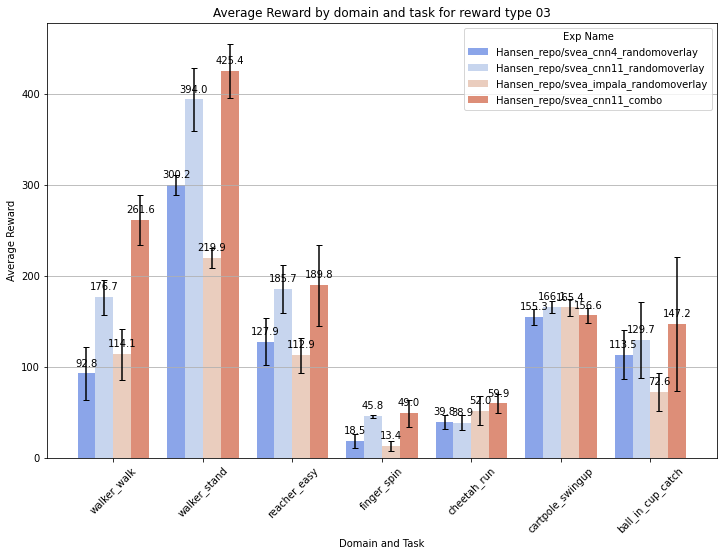

                                       Average Reward
Exp Name                                             
Hansen_repo/svea_cnn11_combo               184.215358
Hansen_repo/svea_cnn11_randomoverlay       162.405342
Hansen_repo/svea_cnn4_randomoverlay        121.133398
Hansen_repo/svea_impala_randomoverlay      107.187813


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



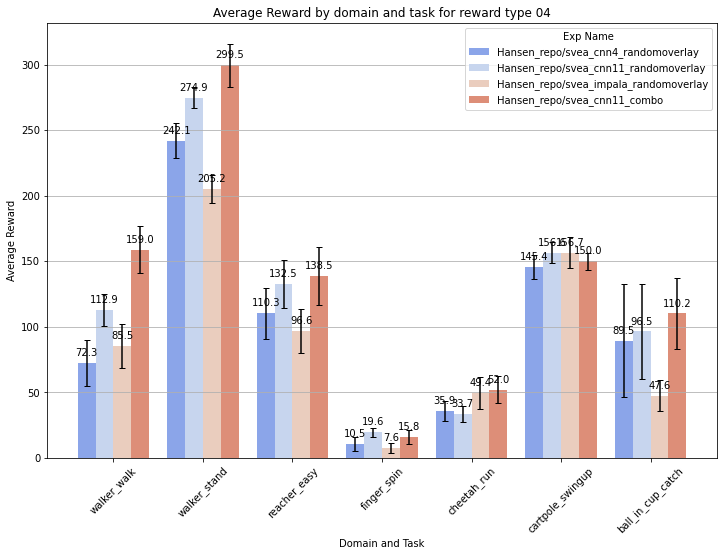

                                       Average Reward
Exp Name                                             
Hansen_repo/svea_cnn11_combo               132.162801
Hansen_repo/svea_cnn11_randomoverlay       118.084587
Hansen_repo/svea_cnn4_randomoverlay        100.862346
Hansen_repo/svea_impala_randomoverlay       92.662894


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



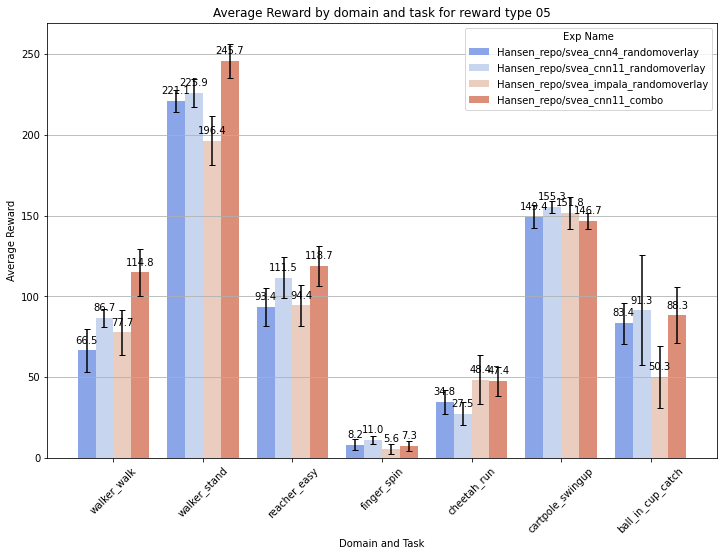

                                       Average Reward
Exp Name                                             
Hansen_repo/svea_cnn11_combo               109.841740
Hansen_repo/svea_cnn11_randomoverlay       101.323612
Hansen_repo/svea_cnn4_randomoverlay         93.821486
Hansen_repo/svea_impala_randomoverlay       89.212260


/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel_launcher.py:174: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



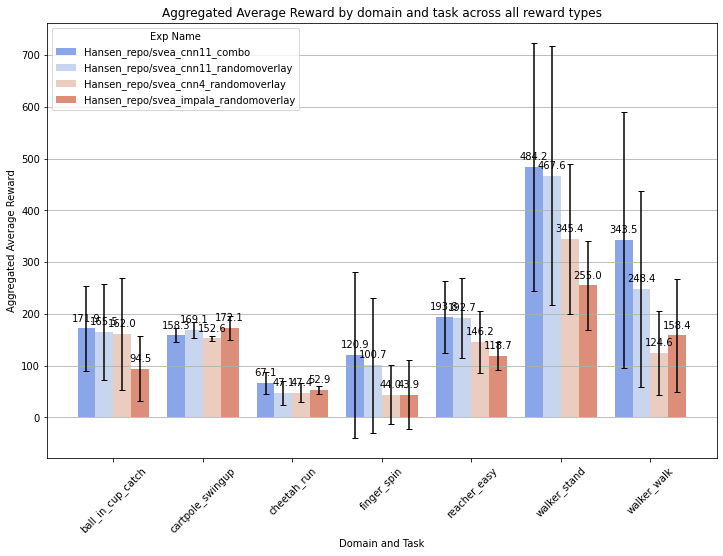

Exp Name
Hansen_repo/svea_cnn11_combo             219.948003
Hansen_repo/svea_cnn11_randomoverlay     198.728493
Hansen_repo/svea_cnn4_randomoverlay      146.025265
Hansen_repo/svea_impala_randomoverlay    127.933990
Name: mean_reward, dtype: float64

In [10]:
import torch
import os
import glob
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"
rl_playground_log_dir = "/home/nas2_userI/byungkunlee/research/rl/RL_playground/dmc/pretrained_model"

def load_data(log_dir, exp_name):
    # Replace with your data loading logic
    exp_log_dir = Path(log_dir) / exp_name
    # Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
    distracting_cs_pt_files = glob.glob(str(exp_log_dir / '**' / 'distractingcs_evalresults.pt'), recursive=True)
    
    # Create a dictionary with keys as "domain_task" and values as paths to .pt files
    distracting_cs_pt_files_dict = {}
    
    for pt_file in distracting_cs_pt_files:
        # Split the file path into components
        components = pt_file.split(os.sep)
        # Get the domain and task names (adjust the indices as per your directory structure)
        if log_dir == rl_playground_log_dir:
            domain_name = components[-5]
            task_name = components[-3]
        else:
            domain_name = components[-3]
            task_name = components[-2]

        # Create a key combining domain and task names
        key = f"{domain_name}_{task_name}"
        
        # Add the file path to the dictionary
        distracting_cs_pt_files_dict[key] = torch.load(pt_file)
    
    # Print the dictionary
    print(len(distracting_cs_pt_files_dict.keys()))
    #assert len(distracting_cs_pt_files_dict.keys()) == 35

    # Dictionary to store rewards per task (domain_task as key)
    reward_data = defaultdict(lambda: defaultdict(list))

    # Populate reward_data with reward values from data_dict
    for key, value in distracting_cs_pt_files_dict.items():
        if log_dir == rl_playground_log_dir:
            domain_task = "_".join(key.split("_")[:-2])
            reward_data[domain_task]['01'].append(value.get('distracting_cs_01', 0))
            reward_data[domain_task]['02'].append(value.get('distracting_cs_02', 0))
            reward_data[domain_task]['03'].append(value.get('distracting_cs_03', 0))
            reward_data[domain_task]['04'].append(value.get('distracting_cs_04', 0))
            reward_data[domain_task]['05'].append(value.get('distracting_cs_05', 0))
        else:
            domain_task = "_".join(key.split("_")[:-1])
            reward_data[domain_task]['01'].append(value.get('distractingcs 01 reward', 0))
            reward_data[domain_task]['02'].append(value.get('distractingcs 02 reward', 0))
            reward_data[domain_task]['03'].append(value.get('distractingcs 03 reward', 0))
            reward_data[domain_task]['04'].append(value.get('distractingcs 04 reward', 0))
            reward_data[domain_task]['05'].append(value.get('distractingcs 05 reward', 0))

    # Creating a DataFrame to hold all the data
    data = []

    for task, rewards in reward_data.items():
        data.append([task, '01', np.mean(rewards['01']), np.std(rewards['01'])])
        data.append([task, '02', np.mean(rewards['02']), np.std(rewards['02'])])
        data.append([task, '03', np.mean(rewards['03']), np.std(rewards['03'])])
        data.append([task, '04', np.mean(rewards['04']), np.std(rewards['04'])])
        data.append([task, '05', np.mean(rewards['05']), np.std(rewards['05'])])
    
    df = pd.DataFrame(data, columns=['Task', 'Reward Type', 'Average Reward', 'STD'])
    df['Exp Name'] = exp_name
    return df
    

# List of exp_names
# exp_names = ["Hansen_repo/svea_cnn4_randomoverlay", 
#              "Hansen_repo/svea_cnn11_randomoverlay"] 
# List of exp_names

exp_names = ["Hansen_repo/svea_cnn4_randomoverlay", 
             "Hansen_repo/svea_cnn11_randomoverlay",             
             "Hansen_repo/svea_impala_randomoverlay",
             "Hansen_repo/svea_cnn11_combo",
             # "dmcgb_reset/svea_cnn4_randomoverlay_policy_reset_rr1", 
             # "dmcgb_reset/svea_cnn11_randomoverlay_policy_reset_rr1",
             ] 

# rl_playground_exp_names = ["svea/svea_cnn11_randomoverlay"]
rl_playground_exp_names = []

# Create a DataFrame for each exp_name and store them in a list
hansen_dfs = [load_data(log_dir, exp_name) for exp_name in exp_names]
rl_playground_dfs = [load_data(rl_playground_log_dir, exp_name) for exp_name in rl_playground_exp_names]
hansen_dfs = hansen_dfs + rl_playground_dfs
# Concatenate all DataFrames
df = pd.concat(hansen_dfs, ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

unique_reward_types = df['Reward Type'].unique()
for reward_type in unique_reward_types:

    # Subset the data for the current reward type
    subset_df = df[df['Reward Type'] == reward_type].reset_index(drop=True)

    # Create a new figure for each reward type with increased size
    plt.figure(figsize=(12, 8))
    
    # Create the bar plot without seaborn's error bars
    barplot = sns.barplot(x='Task', y='Average Reward', hue='Exp Name', data=subset_df, ci=None, capsize=.1, palette='coolwarm')

    for i, patch in enumerate(barplot.patches):
        # Finding the corresponding data point
        y_value = patch.get_height()
        x_value = patch.get_x() + patch.get_width() / 2.0
        
        hue_col = barplot.get_legend().texts[i // len(subset_df['Task'].unique())].get_text()
        x_tick_label = barplot.get_xticklabels()[i % len(subset_df['Task'].unique())].get_text()

        correct_avg_reward = subset_df[(subset_df['Task'] == x_tick_label) & 
                                    (subset_df['Exp Name'] == hue_col)]['Average Reward'].values[0]

        std_dev = subset_df[(subset_df['Task'] == x_tick_label) & 
                            (subset_df['Exp Name'] == hue_col)]['STD'].values[0]

        # Annotate the bars with the average reward values from the subset_df
        barplot.annotate(
            f"{correct_avg_reward:.1f}", 
            (x_value, y_value),
            ha='center', va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
        
        # Adding custom error bars
        barplot.errorbar(
            x=x_value, 
            y=y_value, 
            yerr=std_dev, 
            color='black',
            capsize=3
        )
    
    # Set the title to include the reward type
    plt.title(f'Average Reward by domain and task for reward type {reward_type}')
    
    # Setting the labels and title
    plt.xlabel('Domain and Task')
    plt.ylabel('Average Reward')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # Show the plot
    plt.show()

    abcd = subset_df[['Average Reward', 'Exp Name']].groupby('Exp Name').mean()
    print(abcd)


agg_df = df.groupby(['Exp Name', 'Task'], as_index=False).agg(
    mean_reward=pd.NamedAgg(column='Average Reward', aggfunc='mean'),
    std_reward=pd.NamedAgg(column='Average Reward', aggfunc='std')
)

# Create a new figure for the aggregated data
plt.figure(figsize=(12, 8))

# Create the bar plot without seaborn's error bars
barplot = sns.barplot(x='Task', y='mean_reward', hue='Exp Name', data=agg_df, ci=None, capsize=.1, palette='coolwarm')

# Add annotations and error bars to the barplot
for i, patch in enumerate(barplot.patches):
    # Finding the corresponding data point
    y_value = patch.get_height()
    x_value = patch.get_x() + patch.get_width() / 2.0

    hue_col = barplot.get_legend().texts[i // len(agg_df['Task'].unique())].get_text()
    x_tick_label = barplot.get_xticklabels()[i % len(agg_df['Task'].unique())].get_text()

    correct_avg_reward = agg_df[(agg_df['Task'] == x_tick_label) & 
                                (agg_df['Exp Name'] == hue_col)]['mean_reward'].values[0]

    std_dev = agg_df[(agg_df['Task'] == x_tick_label) & 
                    (agg_df['Exp Name'] == hue_col)]['std_reward'].values[0]

    # Annotate the bars with the average reward values from the agg_df
    barplot.annotate(
        f"{correct_avg_reward:.1f}", 
        (x_value, y_value),
        ha='center', va='center', 
        xytext=(0, 10), 
        textcoords='offset points'
    )
    
    # Adding custom error bars
    barplot.errorbar(
        x=x_value, 
        y=y_value, 
        yerr=std_dev, 
        color='black',
        capsize=3
    )

# Set the title for the aggregated data plot
plt.title('Aggregated Average Reward by domain and task across all reward types')

# Setting the labels and title
plt.xlabel('Domain and Task')
plt.ylabel('Aggregated Average Reward')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()
abcd = agg_df.groupby('Exp Name')
abcd['mean_reward'].mean()

In [22]:
log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"
exp_name = ["Hansen_repo/svea_cnn11_combo", "Hansen_repo/svea_cnn11_randomoverlay", "Hansen_repo/svea_cnn4_randomoverlay",
           "Hansen_repo/svea_impala_randomoverlay"]
domain_task_name = "walker_walk"
seed= "0"

distracting_results = {}
for exp in exp_name:
    # Replace with your data loading logic
    exp_log_dir = Path(log_dir) / exp
    # Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
    distracting_cs_pt_files = glob.glob(str(exp_log_dir / '**'/ domain_task_name / seed / '**'/ 'distractingcs_evalresults.pt'), recursive=True)
    distracting_results[exp] = {}
    for key, value in torch.load(distracting_cs_pt_files[0]).items():
        if key == 'args':
            continue
        distracting_results[exp][key] = value
    

distracting_results

        

{'Hansen_repo/svea_cnn11_combo': {'distractingcs 01 reward': 731.2644938311414,
  'distractingcs 02 reward': 466.94974450238965,
  'distractingcs 03 reward': 246.21956984556127,
  'distractingcs 04 reward': 147.0791061135409,
  'distractingcs 05 reward': 104.82071690947465},
 'Hansen_repo/svea_cnn11_randomoverlay': {'distractingcs 01 reward': 483.7433604013139,
  'distractingcs 02 reward': 304.55158520540255,
  'distractingcs 03 reward': 174.5187237777172,
  'distractingcs 04 reward': 110.83512847155453,
  'distractingcs 05 reward': 83.09092780126828},
 'Hansen_repo/svea_cnn4_randomoverlay': {'distractingcs 01 reward': 267.5249587570917,
  'distractingcs 02 reward': 127.211535410423,
  'distractingcs 03 reward': 90.55774124562822,
  'distractingcs 04 reward': 73.21954791767449,
  'distractingcs 05 reward': 70.00913632857747},
 'Hansen_repo/svea_impala_randomoverlay': {'distractingcs 01 reward': 347.87232652801396,
  'distractingcs 02 reward': 188.69919075987877,
  'distractingcs 03 rew